In [1]:
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator, img_to_array, array_to_img, save_img
from tensorflow.keras.models import Sequential, Model,load_model
from tensorflow.keras.layers import Flatten, GlobalAveragePooling2D, Dense
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image, ExifTags
import os
from matplotlib import pyplot as plt
import tensorflow as tf

In [2]:
print(tf.__version__)

2.3.1


In [3]:
material_labels = {0:'Cardboard', 1:'Chips Bag', 2:'Drinking Carton', 3:'Glass Bottle',
                   4:'Glass Cup', 5:'Metal Can', 6:'Organic', 7:'Paper', 8:'Plastic Bag',
                   9:'Plastic Bottle', 10:'Plastic Box', 11:'Plastic Round Container'}

In [4]:
def prepare_images(image_file):
    
    '''
    Function that prepare images for the three models 
    by resizing the images into the according input size of 
    every model. Normalizing the values by divinding them by 255
    and reshaping the matrix into a 4D tensor
    '''
    
    # fix phone rotating images
    try:
        image=Image.open(image_file)

        for orientation in ExifTags.TAGS.keys():
            if ExifTags.TAGS[orientation]=='Orientation':
                break

        exif = image._getexif()

        if exif[orientation] == 3:
            image=image.rotate(180, expand=True)
        elif exif[orientation] == 6:
            image=image.rotate(270, expand=True)
        elif exif[orientation] == 8:
            image=image.rotate(90, expand=True)

        image.save(image_file)
        image.close()
    except (AttributeError, KeyError, IndexError):
         #cases: image don't have getexif
        pass
    
    # create three different tensors specific for every single model
    image_densenet = (img_to_array(load_img(image_file, target_size = (224,224)))/255.).reshape(1,224,224,3)
    image_inceptionresnet = (img_to_array(load_img(image_file, target_size = (299,299)))/255.).reshape(1,299,299,3)
    image_nasnetlarge = (img_to_array(load_img(image_file, target_size = (331,331)))/255.).reshape(1,331,331,3)
    
    return image_densenet, image_inceptionresnet, image_nasnetlarge

def load_candidate_models(densenet169_file, inceptionresnet_file, nasnetlarge_file):
    
    '''
    Function that returns the three keras hdf5 pretrained models with their respective 
    weights. The return is in the respective order: DenseNet169, InceptionResNet, NASNetLarge
    '''
    
    densenet = load_model(densenet169_file)
    inceptionresnet = load_model(inceptionresnet_file)
    nasnetlarge = load_model(nasnetlarge_file)
    
    return densenet, inceptionresnet, nasnetlarge

def combined_prediction(imgDenseNet, imgInceptionResNet, imgNasnetLarge, denseNet, inceptionResNet, nasNetLarge):
    
    '''
    Function that returns the combined prediction of the three models
    '''
    material_labels = {0:'Cardboard', 1:'Chips Bag', 2:'Drinking Carton', 3:'Glass Bottle',
                   4:'Glass Cup', 5:'Metal Can', 6:'Organic', 7:'Paper', 8:'Plastic Bag',
                   9:'Plastic Bottle', 10:'Plastic Box', 11:'Plastic Round Container'}
    
    # To avoid Tensorflow warning about tracing, I used the below method to get the prediction
    # out of every model
    densenet_prediction = np.argmax((denseNet(imgDenseNet)).numpy(), axis = -1)
    inceptionresnet_prediction = np.argmax((inceptionResNet(imgInceptionResNet)).numpy(), axis = -1)
    nasnetlarge_prediction = np.argmax((nasNetLarge(imgNasnetLarge)).numpy(), axis = -1)
    
    prediction_list = [material_labels[int(densenet_prediction)], material_labels[int(inceptionresnet_prediction)],
                                      material_labels[int(nasnetlarge_prediction)]]
    df = pd.DataFrame(prediction_list, columns = {"Predicted Label"})
    if df["Predicted Label"].value_counts().max() >= 2:
        combined_prediction = df["Predicted Label"].value_counts().idxmax()
        votes = df["Predicted Label"].value_counts().max()
    else:
        combined_prediction = "No definitive decision about predictions"
        votes = 0
    
    prediction_data = {"Combined Predicted Label": combined_prediction,
                       "Combined Votes": votes,
                       "DenseNet169 Predicted Label" : material_labels[int(densenet_prediction)],
                       "ResNetInception Predicted Label" : material_labels[int(inceptionresnet_prediction)],
                       "NASNetLarge Predicted Label" : material_labels[int(nasnetlarge_prediction)]
                      }
    return prediction_data
    
    

In [5]:
densenet_path = "/Users/fouad/Desktop/HU - Master Data Driven Design/Graduation/Models/densenet169_model.h5"
inceptionresnet_path = "/Users/fouad/Desktop/HU - Master Data Driven Design/Graduation/Models/inceptionresnet_model.h5"
nasnetlarge_path = "/Users/fouad/Desktop/HU - Master Data Driven Design/Graduation/Models/nasnetlarge_model.h5"


densenet169, inceptionresnet, nasnetlarge = load_candidate_models(densenet_path, inceptionresnet_path, nasnetlarge_path)

In [13]:
image_path = "/Users/fouad/Desktop/HU - Master Data Driven Design/Graduation/Project/My_Recycle_Friend/media/history_images/image_7.jpg"
#img_densenet, img_inceptionresnet, img_nasnetlarge = prepare_images(image_path)
img_densenet = (img_to_array(load_img(image_path, target_size = (224,224)))/255.).reshape(1,224,224,3)
img_inceptionresnet = (img_to_array(load_img(image_path, target_size = (299,299)))/255.).reshape(1,299,299,3)
img_nasnetlarge = (img_to_array(load_img(image_path, target_size = (331,331)))/255.).reshape(1,331,331,3)

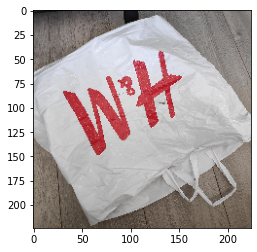

In [14]:
image_display = load_img(image_path, target_size = (224,224))
plt.imshow(image_display)
plt.show()

In [15]:
predictions = combined_prediction(img_densenet, img_inceptionresnet, img_nasnetlarge, 
                                  densenet169, inceptionresnet, nasnetlarge)
predictions

{'Combined Predicted Label': 'Plastic Bag',
 'Combined Votes': 3,
 'DenseNet169 Predicted Label': 'Plastic Bag',
 'ResNetInception Predicted Label': 'Plastic Bag',
 'NASNetLarge Predicted Label': 'Plastic Bag'}

In [16]:
predictions["Combined Predicted Label"]

'Plastic Bag'